# Vision AI Fun

In [1]:
from typing import Sequence
import os

# to show images being submitted
from google.cloud import storage
from IPython.display import Image
import base64
import numpy as np
import argparse
import cv2
import io
import urllib

from google.cloud import vision


In [2]:
SERIES = 'applied_apis'
EXPERIMENT = 'vision_ai_fun'

REGION = 'us-central1'

In [3]:
DIR = f"temp/{EXPERIMENT}"

In [4]:
!rm -rf {DIR}
!mkdir -p {DIR}

In [5]:
gcs_client = storage.Client()
vision_client = vision.ImageAnnotatorClient()

Functions:

In [6]:
def analyze_image_from_uri(image_uri: str,feature_types: Sequence,) -> vision.AnnotateImageResponse:
    client = vision.ImageAnnotatorClient()

    image = vision.Image()
    image.source.image_uri = image_uri
    features = [vision.Feature(type_=feature_type) for feature_type in feature_types]
    request = vision.AnnotateImageRequest(image=image, features=features)

    response = client.annotate_image(request=request)

    return response

def analyze_image_local(image_uri: str, feature_types: Sequence,) -> vision.AnnotateImageResponse:
    client = vision.ImageAnnotatorClient()
    
    with io.open(image_uri, "rb") as f:
        byteImage = f.read()

    image = vision.Image(content=byteImage)
    features = [vision.Feature(type_=feature_type) for feature_type in feature_types]
    request = vision.AnnotateImageRequest(image=image, features=features)

    response = client.annotate_image(request=request)

    return response


In [7]:
def draw_box_results(image, rect, color=(0, 255, 0)):
    # unpacking the bounding box rectangle and draw a bounding box
    (startX, startY, endX, endY) = rect
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    # return the output image
    return image


In [8]:
def draw_box_text_results(image, text, rect, color=(0, 255, 0)):
    # unpacking the bounding box rectangle and draw a bounding box
    # surrounding the text along with the OCR'd text itself
    (startX, startY, endX, endY) = rect
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    cv2.putText(image, text, (startX + 20, startY + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    # return the output image
    return image


In [9]:
def draw_face_points(image, point, color=(0, 255, 0)):
    # unpacking the bounding box rectangle and draw a bounding box
    # surrounding the text along with the OCR'd text itself
    (pointX, pointY) = point
    cv2.circle(image, (pointX, pointY), radius = 5, color = color, thickness=-1)

    # return the output image
    return image

## Label Detection

In [10]:
def print_labels(response: vision.AnnotateImageResponse):
    print("=" * 80)
    for label in response.label_annotations:
        print(
            f"{label.score:4.0%}",
            f"{label.description:5}",
            sep=" | ",
        )


In [11]:
bucket_text = 'cloud-samples-data'
bucket = gcs_client.get_bucket(bucket_text)
image_name = 'setagaya.jpeg'
blob_text = 'vision/label/' + image_name
blob = bucket.get_blob(blob_text)

blob.download_to_filename(DIR + '/' + image_name)
image_1 = DIR + '/' + image_name

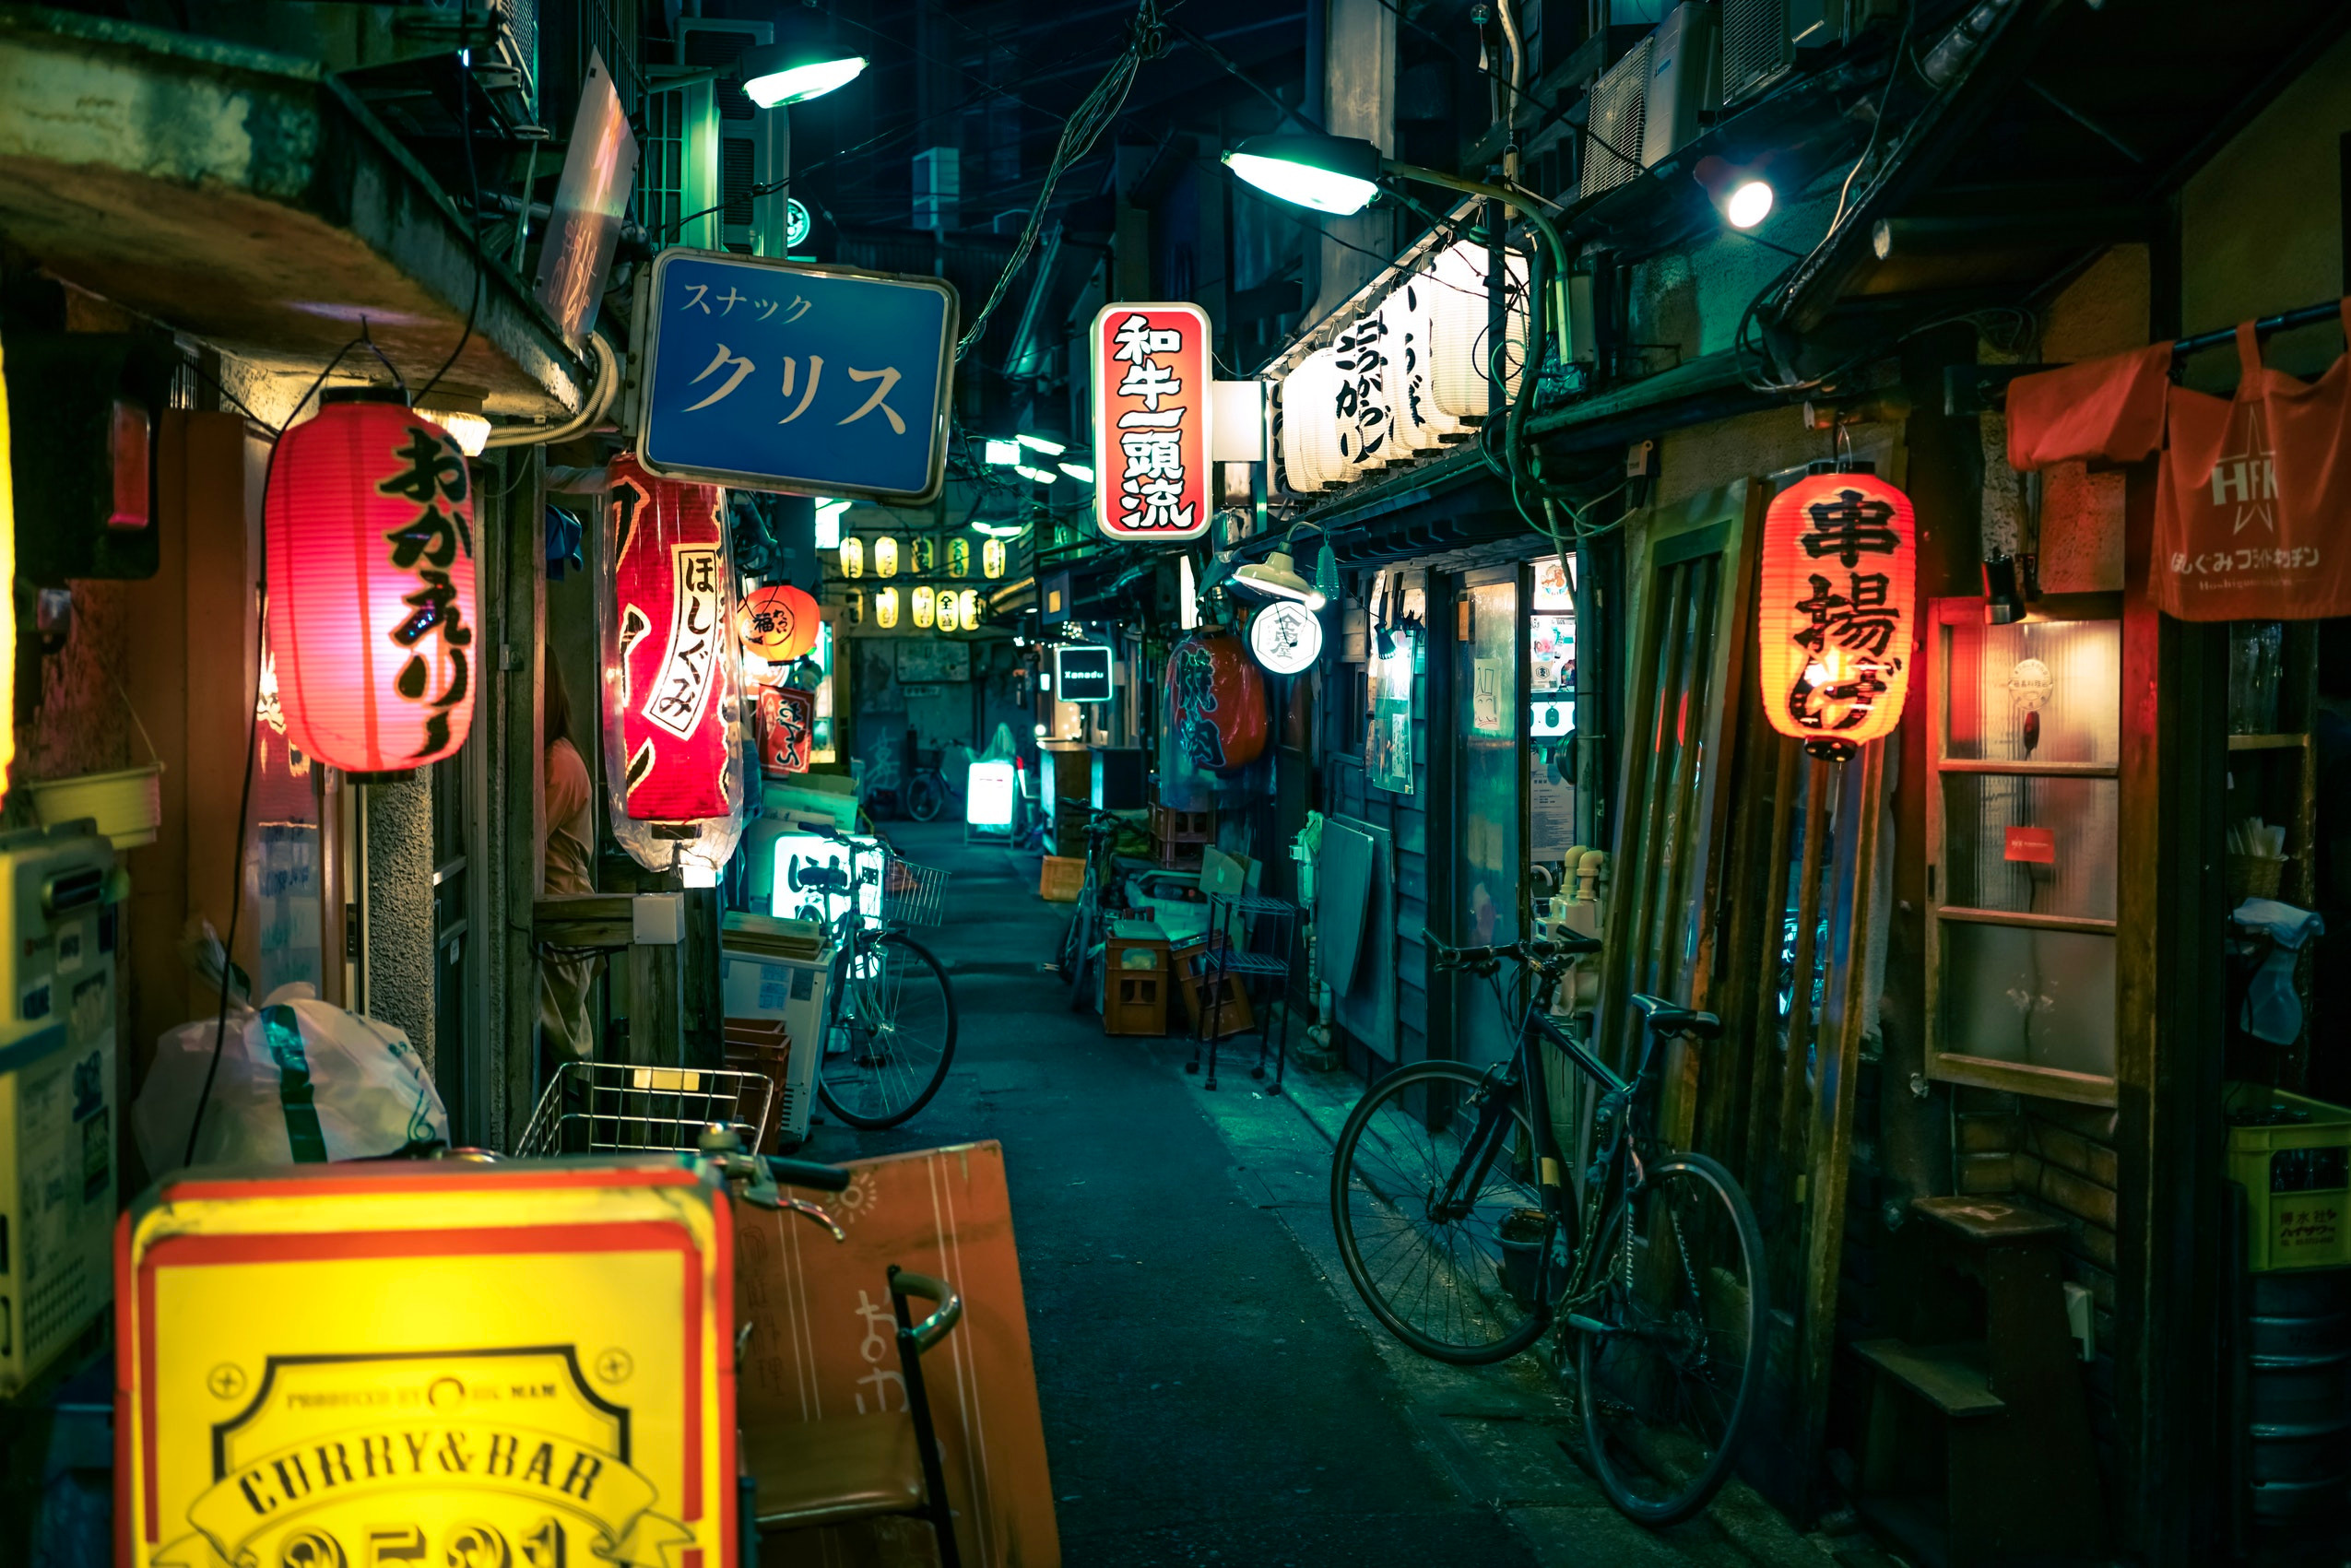

In [12]:
Image(image_1)

In [13]:
with io.open(image_1, "rb") as f:
    byteImage = f.read()

In [14]:
image = vision.Image(content=byteImage)
response = vision_client.label_detection(image=image)
#response

In [15]:
# using local image
features = [vision.Feature.Type.LABEL_DETECTION]

response = analyze_image_local(image_1, features)
print_labels(response)


 97% | Bicycle
 96% | Tire 
 94% | Wheel
 91% | Automotive lighting
 89% | Infrastructure
 87% | Bicycle wheel
 86% | Mode of transport
 85% | Building
 83% | Electricity
 82% | Neighbourhood


In [16]:
# using image in GCS
image_1_uri = 'gs://' + bucket_text + '/' + blob_text

features = [vision.Feature.Type.LABEL_DETECTION]

response = analyze_image_from_uri(image_1_uri, features)
print_labels(response)


 97% | Bicycle
 96% | Tire 
 94% | Wheel
 91% | Automotive lighting
 89% | Infrastructure
 87% | Bicycle wheel
 86% | Mode of transport
 85% | Building
 83% | Electricity
 82% | Neighbourhood


## Text Detection

In [17]:
def print_text(response: vision.AnnotateImageResponse):
    print("=" * 80)
    for annotation in response.text_annotations:
        vertices = [f"({v.x},{v.y})" for v in annotation.bounding_poly.vertices]
        print(
            f"{repr(annotation.description):42}",
            ",".join(vertices),
            sep=" | ",
        )
        

In [18]:
bucket_text = 'cloud-samples-data'
bucket = gcs_client.get_bucket(bucket_text)
image_name = 'sign.jpg'
blob_text = 'vision/ocr/' + image_name
blob = bucket.get_blob(blob_text)

blob.download_to_filename(DIR + '/' + image_name)
image_2 = DIR + '/' + image_name

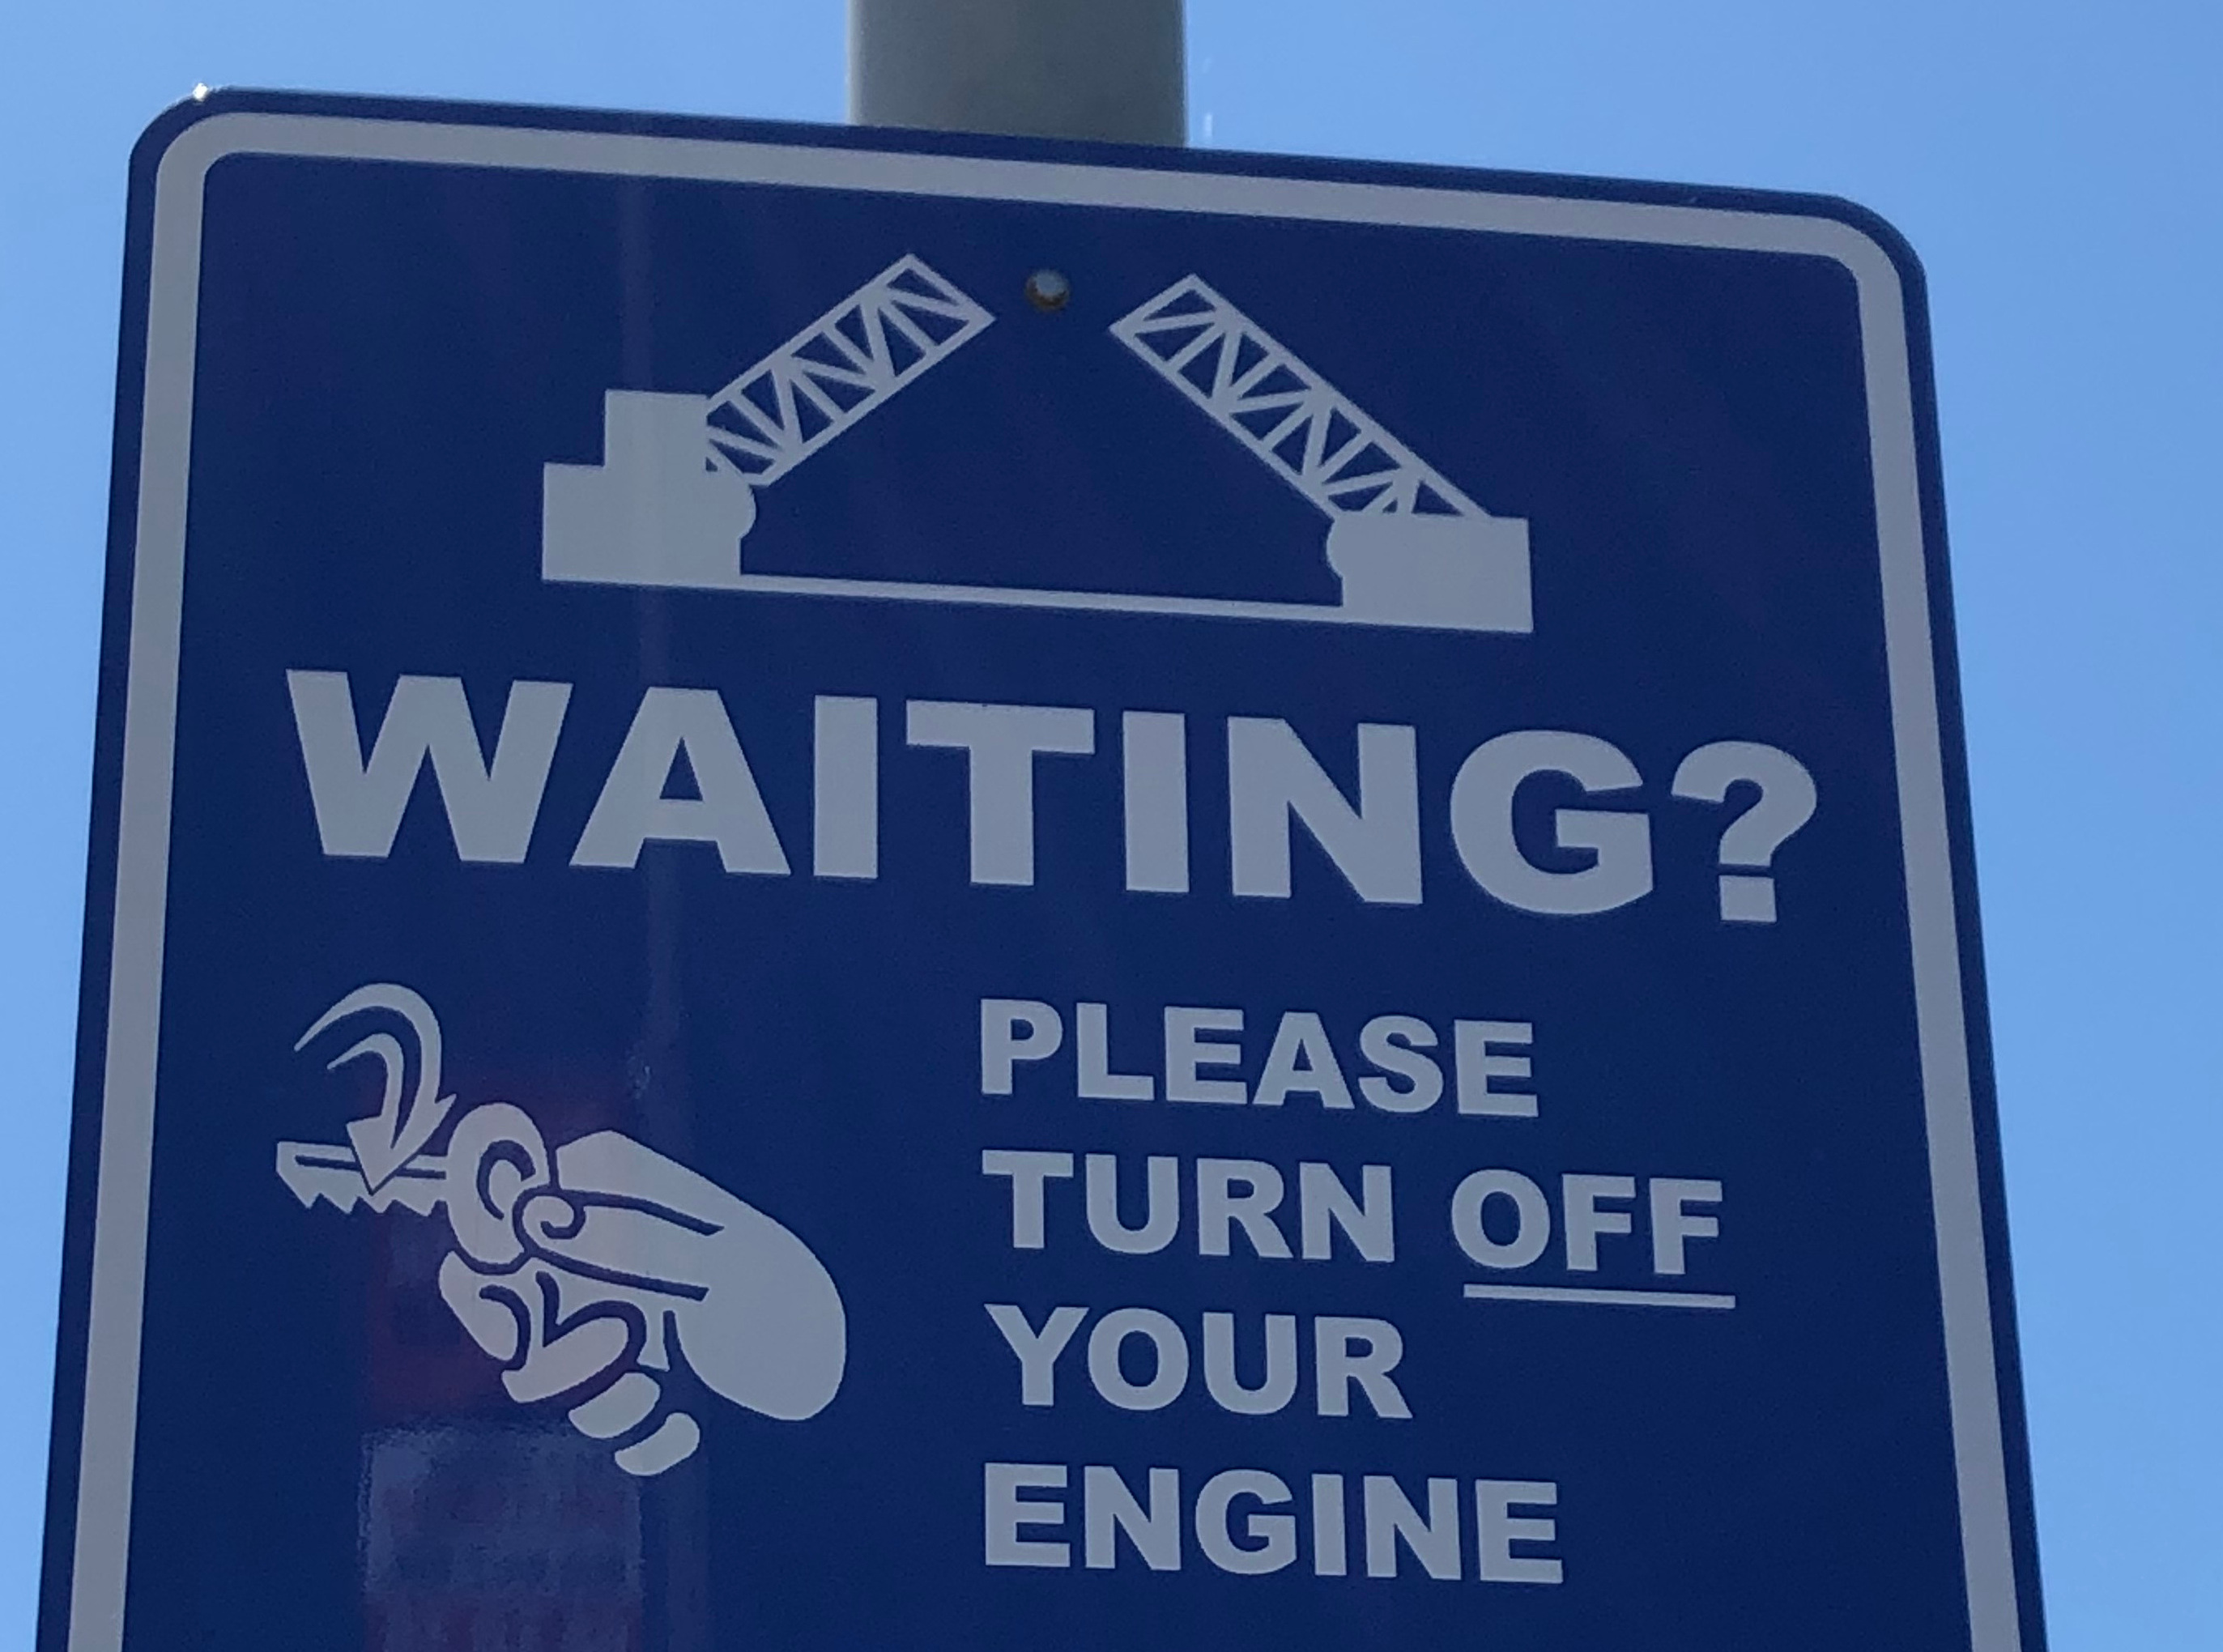

In [19]:
Image(image_2)

In [20]:
with io.open(image_2, "rb") as f:
    byteImage = f.read()

In [21]:
image = vision.Image(content=byteImage)
response = vision_client.text_detection(image=image)
#response

In [22]:
image = cv2.imread(image_2)
final = image.copy()


In [23]:
# loop over the Google Cloud Vision API results and draw bounding boxes

for text in response.text_annotations:
    # grab the OCR'd text and extract the bounding box coordinates of
    # the text region
    startX = text.bounding_poly.vertices[0].x
    startY = text.bounding_poly.vertices[0].y
    endX = text.bounding_poly.vertices[1].x
    endY = text.bounding_poly.vertices[2].y
    # construct a bounding box rectangle from the box coordinates
    rect = (startX, startY, endX, endY)
    
    # draw the output OCR line-by-line
    #output = image.copy()
    #output = draw_ocr_results(output, rect)
    final = draw_box_results(final, rect)
    # show the output OCR'd line
    #cv2.imshow("Output", output)
    #cv2.waitKey(0)
    
cv2.startWindowThread()
    
# show the final output image
cv2.imshow('Final Output', final)

cv2.waitKey(0)

cv2.destroyAllWindows()
cv2.waitKey(1)


-1

In [24]:
features = [vision.Feature.Type.TEXT_DETECTION]

response = analyze_image_local(image_2, features)
print_text(response)


'WAITING?\nPLEASE\nTURN OFF\nYOUR\nENGINE' | (310,821),(2225,821),(2225,1965),(310,1965)
'WAITING'                                  | (344,821),(2025,879),(2016,1127),(335,1069)
'?'                                        | (2057,881),(2225,887),(2216,1134),(2048,1128)
'PLEASE'                                   | (1207,1231),(1895,1254),(1891,1374),(1203,1351)
'TURN'                                     | (1217,1414),(1718,1434),(1712,1559),(1212,1539)
'OFF'                                      | (1787,1437),(2133,1451),(2128,1576),(1782,1562)
'YOUR'                                     | (1211,1609),(1741,1626),(1737,1747),(1207,1731)
'ENGINE'                                   | (1213,1805),(1922,1819),(1919,1949),(1210,1935)


In [25]:
image_2_uri = 'gs://' + bucket_text + '/' + blob_text
image_2_uri

features = [vision.Feature.Type.TEXT_DETECTION]

response = analyze_image_from_uri(image_2_uri, features)
print_text(response)

'WAITING?\nPLEASE\nTURN OFF\nYOUR\nENGINE' | (310,821),(2225,821),(2225,1965),(310,1965)
'WAITING'                                  | (344,821),(2025,879),(2016,1127),(335,1069)
'?'                                        | (2057,881),(2225,887),(2216,1134),(2048,1128)
'PLEASE'                                   | (1207,1231),(1895,1254),(1891,1374),(1203,1351)
'TURN'                                     | (1217,1414),(1718,1434),(1712,1559),(1212,1539)
'OFF'                                      | (1787,1437),(2133,1451),(2128,1576),(1782,1562)
'YOUR'                                     | (1211,1609),(1741,1626),(1737,1747),(1207,1731)
'ENGINE'                                   | (1213,1805),(1922,1819),(1919,1949),(1210,1935)


## Landmark Detection

In [26]:
def print_landmarks(response: vision.AnnotateImageResponse, min_score: float = 0.5):
    print("=" * 80)
    for landmark in response.landmark_annotations:
        if landmark.score < min_score:
            continue
        vertices = [f"({v.x},{v.y})" for v in landmark.bounding_poly.vertices]
        lat_lng = landmark.locations[0].lat_lng
        print(
            f"{landmark.score:4.0%}",
            f"{landmark.description:18}",
            ",".join(vertices),
            f"{lat_lng.latitude:.5f}",
            f"{lat_lng.longitude:.5f}",
            sep=" | ",
        )
        

In [27]:
bucket_text = 'cloud-samples-data'
bucket = gcs_client.get_bucket(bucket_text)
image_name = 'eiffel_tower.jpg'
blob_text = 'vision/landmark/' + image_name
blob = bucket.get_blob(blob_text)

blob.download_to_filename(DIR + '/' + image_name)
image_3 = DIR + '/' + image_name

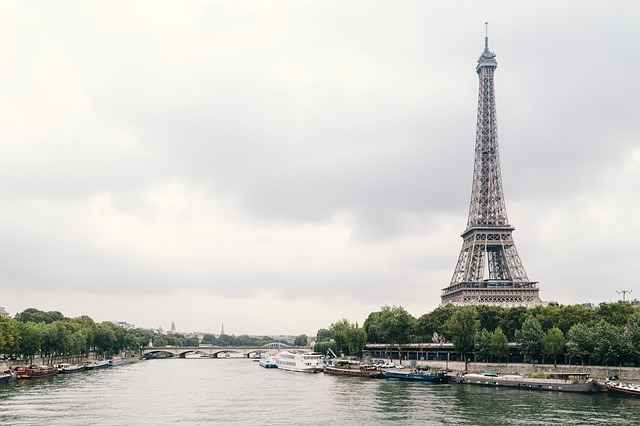

In [28]:
Image(image_3)

In [29]:
with io.open(image_3, "rb") as f:
    byteImage = f.read()

In [30]:
image = vision.Image(content=byteImage)
response = vision_client.landmark_detection(image=image)
#response

In [31]:
image = cv2.imread(image_3)
final = image.copy()


In [32]:
# loop over the Google Cloud Vision API results and draw bounding boxes with text

for text in response.landmark_annotations:
    # grab the OCR'd text and extract the bounding box coordinates of
    # the text region
    ocr = text.description
    startX = text.bounding_poly.vertices[0].x
    startY = text.bounding_poly.vertices[0].y
    endX = text.bounding_poly.vertices[1].x
    endY = text.bounding_poly.vertices[2].y
    # construct a bounding box rectangle from the box coordinates
    rect = (startX, startY, endX, endY)
    
    # draw the output OCR line-by-line
    #output = image.copy()
    #output = draw_ocr_results(output, ocr, rect)
    final = draw_box_text_results(final, ocr, rect)
    # show the output OCR'd line
    #cv2.imshow("Output", output)
    #cv2.waitKey(0)
    
cv2.startWindowThread()
    
# show the final output image
cv2.imshow('Final Output', final)

cv2.waitKey(0)

cv2.destroyAllWindows()
cv2.waitKey(1)


-1

In [33]:
features = [vision.Feature.Type.LANDMARK_DETECTION]

response = analyze_image_local(image_3, features)
print_landmarks(response)


 86% | Champ De Mars      | (0,0),(640,0),(640,426),(0,426) | 48.85565 | 2.29863
 79% | Pont De Bir-Hakeim | (0,0),(640,0),(640,426),(0,426) | 48.85560 | 2.28759
 75% | Eiffel Tower       | (0,0),(640,0),(640,426),(0,426) | 48.85837 | 2.29448


In [34]:
image_3_uri = 'gs://' + bucket_text + '/' + blob_text
image_3_uri

features = [vision.Feature.Type.LANDMARK_DETECTION]

response = analyze_image_from_uri(image_3_uri, features)
print_landmarks(response)

 86% | Champ De Mars      | (0,0),(640,0),(640,426),(0,426) | 48.85565 | 2.29863
 79% | Pont De Bir-Hakeim | (0,0),(640,0),(640,426),(0,426) | 48.85560 | 2.28759
 75% | Eiffel Tower       | (0,0),(640,0),(640,426),(0,426) | 48.85837 | 2.29448


## Face Detection

In [35]:
def print_faces(response: vision.AnnotateImageResponse):
    print("=" * 80)
    for face_number, face in enumerate(response.face_annotations, 1):
        vertices = ",".join(f"({v.x},{v.y})" for v in face.bounding_poly.vertices)
        print(f"# Face {face_number} @ {vertices}")
        print(f"Joy:     {face.joy_likelihood.name}")
        print(f"Exposed: {face.under_exposed_likelihood.name}")
        print(f"Blurred: {face.blurred_likelihood.name}")
        print("-" * 80)
        

In [36]:
bucket_text = 'cloud-samples-data'
bucket = gcs_client.get_bucket(bucket_text)
image_name = 'faces.jpeg'
blob_text = 'vision/face/' + image_name
blob = bucket.get_blob(blob_text)

blob.download_to_filename(DIR + '/' + image_name)
image_4 = DIR + '/' + image_name

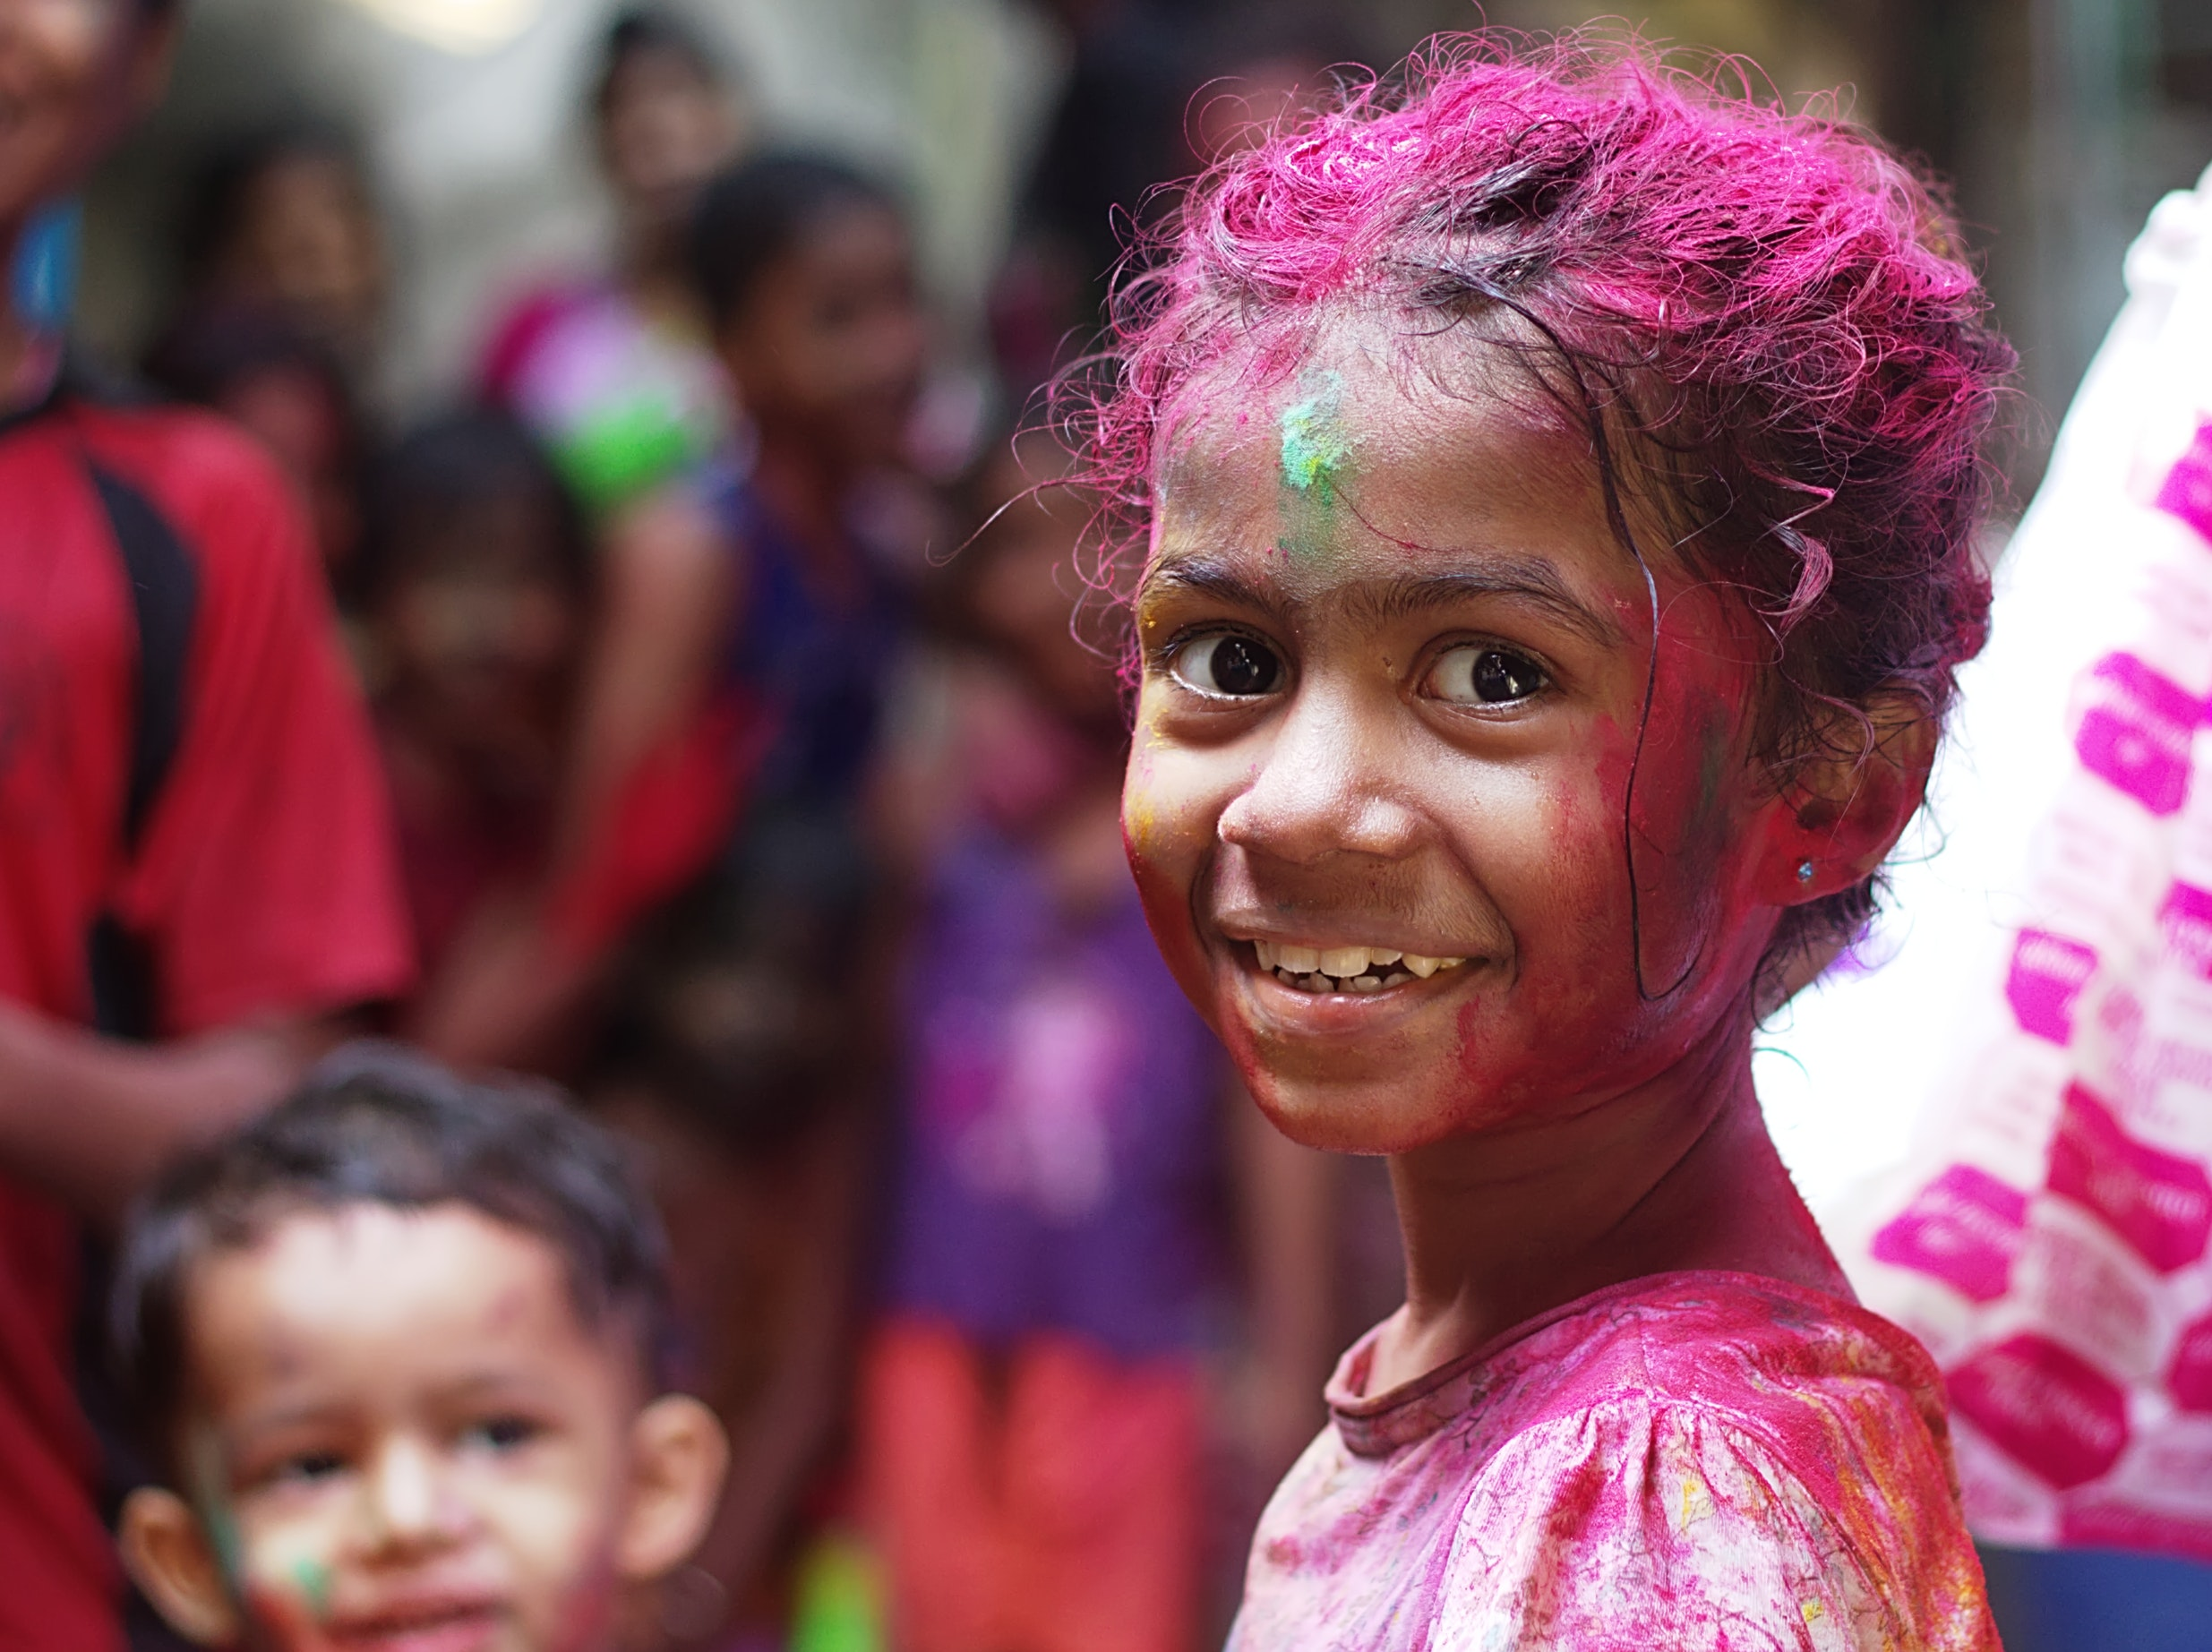

In [37]:
Image(image_4)

In [38]:
with io.open(image_4, "rb") as f:
    byteImage = f.read()

In [39]:
image = vision.Image(content=byteImage)
response = vision_client.face_detection(image=image)


In [40]:
image = cv2.imread(image_4)
final = image.copy()


In [41]:
# loop over the Google Cloud Vision API results and draw bounding boxes

for number, text in enumerate(response.face_annotations, 1):
    # grab the OCR'd text and extract the bounding box coordinates of
    # the text region
    face = 'Face Number: ' + str(number)
    startX = text.bounding_poly.vertices[0].x
    startY = text.bounding_poly.vertices[0].y
    endX = text.bounding_poly.vertices[1].x
    endY = text.bounding_poly.vertices[2].y
    # construct a bounding box rectangle from the box coordinates
    rect = (startX, startY, endX, endY)
    
    final = draw_box_text_results(final, face, rect)

# create point lists
x = []
y = []
for i in response.face_annotations:
    for j in i.landmarks:
        x.append(j.position.x)
        y.append(j.position.y)
points = np.column_stack((x, y))

# draw points
for point in points:
    point = (int(point[0]), int(point[1]))
    final = draw_face_points(final, point)
    
cv2.startWindowThread()
    
# show the final output image
cv2.imshow('Final Output', final)

cv2.waitKey(0)

cv2.destroyAllWindows()
cv2.waitKey(1)


-1

In [42]:
features = [vision.Feature.Type.FACE_DETECTION]

response = analyze_image_local(image_4, features)
print_faces(response)


# Face 1 @ (143,1273),(793,1273),(793,1844),(143,1844)
Joy:     VERY_UNLIKELY
Exposed: VERY_UNLIKELY
Blurred: VERY_UNLIKELY
--------------------------------------------------------------------------------
# Face 2 @ (784,170),(1097,170),(1097,534),(784,534)
Joy:     VERY_UNLIKELY
Exposed: VERY_UNLIKELY
Blurred: VERY_UNLIKELY
--------------------------------------------------------------------------------
# Face 3 @ (664,28),(816,28),(816,205),(664,205)
Joy:     VERY_UNLIKELY
Exposed: VERY_UNLIKELY
Blurred: VERY_UNLIKELY
--------------------------------------------------------------------------------
# Face 4 @ (1076,151),(2144,151),(2144,1392),(1076,1392)
Joy:     VERY_LIKELY
Exposed: VERY_UNLIKELY
Blurred: VERY_UNLIKELY
--------------------------------------------------------------------------------


In [43]:
image_4_uri = 'gs://' + bucket_text + '/' + blob_text
image_4_uri

features = [vision.Feature.Type.FACE_DETECTION]

response = analyze_image_from_uri(image_4_uri, features)
print_faces(response)

# Face 1 @ (664,28),(816,28),(816,205),(664,205)
Joy:     VERY_UNLIKELY
Exposed: VERY_UNLIKELY
Blurred: VERY_UNLIKELY
--------------------------------------------------------------------------------
# Face 2 @ (143,1273),(793,1273),(793,1844),(143,1844)
Joy:     VERY_UNLIKELY
Exposed: VERY_UNLIKELY
Blurred: VERY_UNLIKELY
--------------------------------------------------------------------------------
# Face 3 @ (784,170),(1097,170),(1097,534),(784,534)
Joy:     VERY_UNLIKELY
Exposed: VERY_UNLIKELY
Blurred: VERY_UNLIKELY
--------------------------------------------------------------------------------
# Face 4 @ (1076,151),(2144,151),(2144,1392),(1076,1392)
Joy:     VERY_LIKELY
Exposed: VERY_UNLIKELY
Blurred: VERY_UNLIKELY
--------------------------------------------------------------------------------


## Object Detection

In [44]:
def print_objects(response: vision.AnnotateImageResponse):
    print("=" * 80)
    for obj in response.localized_object_annotations:
        nvertices = obj.bounding_poly.normalized_vertices
        print(
            f"{obj.score:4.0%}",
            f"{obj.name:15}",
            f"{obj.mid:10}",
            ",".join(f"({v.x:.1f},{v.y:.1f})" for v in nvertices),
            sep=" | ",
        )
        

In [45]:
bucket_text = 'cloud-samples-data'
bucket = gcs_client.get_bucket(bucket_text)
image_name = 'setagaya.jpeg'
blob_text = 'vision/label/' + image_name
blob = bucket.get_blob(blob_text)

blob.download_to_filename(DIR + '/' + image_name)
image_5 = DIR + '/' + image_name

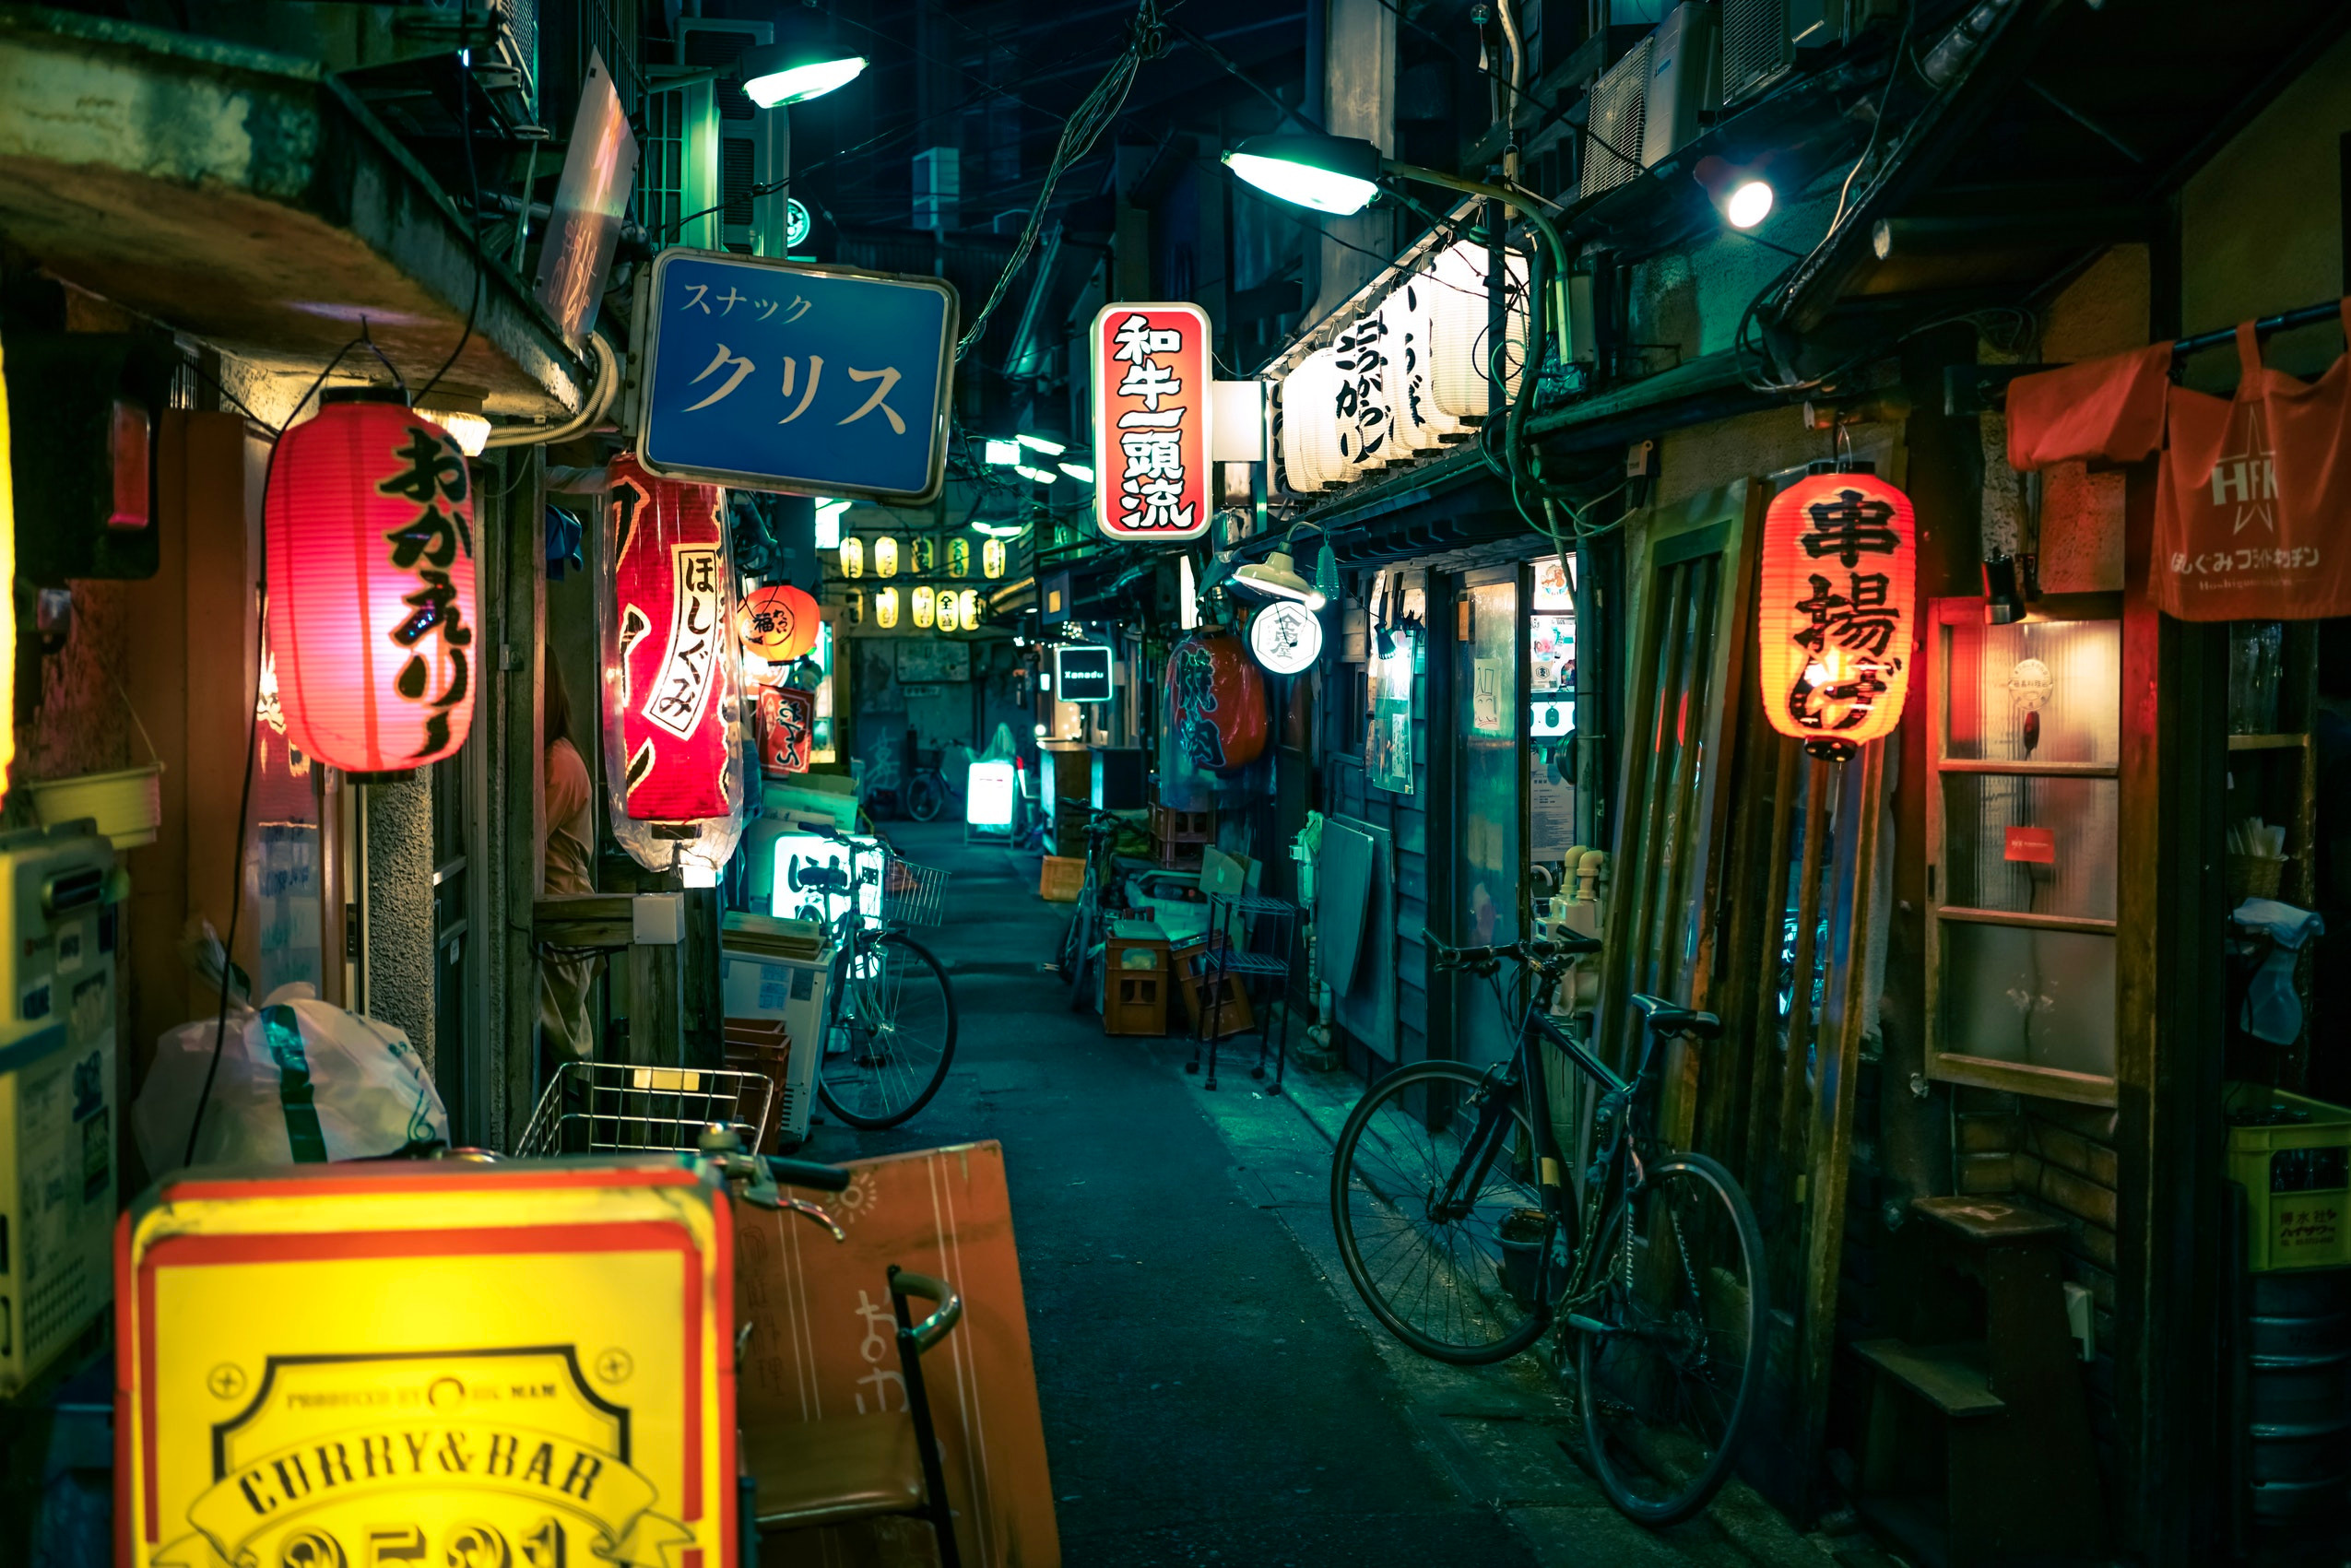

In [46]:
Image(image_5)

In [47]:
with io.open(image_5, "rb") as f:
    byteImage = f.read()

In [48]:
image = vision.Image(content=byteImage)
response = vision_client.object_localization(image=image)
#response

In [49]:
image = cv2.imread(image_5)
final = image.copy()


In [50]:
# loop over the Google Cloud Vision API results and draw bounding boxes

for text in response.localized_object_annotations:
    # grab the OCR'd text and extract the bounding box coordinates of
    # the text region
    name = text.name
    # object localization provides normalized coordinates, so need to convert to actual coordinates using shape of the image
    image_w = image.shape[0]
    image_h = image.shape[1]
    startX = (text.bounding_poly.normalized_vertices[0].x) * image_h
    startY = (text.bounding_poly.normalized_vertices[0].y) * image_w
    endX = (text.bounding_poly.normalized_vertices[1].x) * image_h
    endY = (text.bounding_poly.normalized_vertices[2].y) * image_w
    # construct a bounding box rectangle from the box coordinates
    rect = (int(startX), int(startY), int(endX), int(endY))
    
    final = draw_box_text_results(final, name, rect)
    
cv2.startWindowThread()
    
# show the final output image
cv2.imshow('Final Output', final)

cv2.waitKey(0)

cv2.destroyAllWindows()
cv2.waitKey(1)


-1

In [51]:
features = [vision.Feature.Type.OBJECT_LOCALIZATION]

response = analyze_image_local(image_5, features)
print_objects(response)


 93% | Bicycle         | /m/0199g   | (0.6,0.6),(0.8,0.6),(0.8,0.9),(0.6,0.9)
 92% | Bicycle wheel   | /m/01bqk0  | (0.6,0.7),(0.7,0.7),(0.7,0.9),(0.6,0.9)
 91% | Tire            | /m/0h9mv   | (0.7,0.7),(0.8,0.7),(0.8,1.0),(0.7,1.0)
 75% | Bicycle         | /m/0199g   | (0.3,0.6),(0.4,0.6),(0.4,0.7),(0.3,0.7)
 51% | Tire            | /m/0h9mv   | (0.3,0.6),(0.4,0.6),(0.4,0.7),(0.3,0.7)


In [52]:
image_5_uri = 'gs://' + bucket_text + '/' + blob_text
image_5_uri

features = [vision.Feature.Type.OBJECT_LOCALIZATION]

response = analyze_image_from_uri(image_5_uri, features)
print_objects(response)

 93% | Bicycle         | /m/0199g   | (0.6,0.6),(0.8,0.6),(0.8,0.9),(0.6,0.9)
 92% | Bicycle wheel   | /m/01bqk0  | (0.6,0.7),(0.7,0.7),(0.7,0.9),(0.6,0.9)
 91% | Tire            | /m/0h9mv   | (0.7,0.7),(0.8,0.7),(0.8,1.0),(0.7,1.0)
 75% | Bicycle         | /m/0199g   | (0.3,0.6),(0.4,0.6),(0.4,0.7),(0.3,0.7)
 51% | Tire            | /m/0h9mv   | (0.3,0.6),(0.4,0.6),(0.4,0.7),(0.3,0.7)
